## How to find the best connectivity model for each cerebellar region across datasets? 
We start from a simple hierarchical model 

* Global connectivity model g=$N(0,sigma_g)$ 
* Data set specific variances and covariances $N(0,D)$ where D is the full dataset x dataset covariance matrix
* For each dataset, we generate $n_i$ subjects with $N(0,\sigma^2_{subject,i})$ noise for the $ith dataset. 

Given some data and known covariance structure, what is the best estimator of g?  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PcmPy as pcm

In [2]:
def generate_data(sigma2_g,dataset_cov, dataset_size,subject_var,P=100):
    """Create a random data set with a given hierarchical covariance structure."""
    g=np.random.normal(0,sigma2_g,size=(100,))
    # generate dataset patterns
    n_dataset = len(dataset_size)
    D = np.random.normal(0, 1, (n_dataset, P)) 
    C = np.linalg.cholesky(dataset_cov)
    D = C @ D
    data = []   
    for i in range(n_dataset):
        # generate dataset
        d = np.random.normal(0,np.sqrt(subject_var[i]),size=(dataset_size[i],P)) + D[i] + g 
        data.append(d)
    data = np.concatenate(data, axis=0)
    return data,g,D

def get_indicator_matrix(dataset_size):
    dataset = [np.ones((dataset_size[i],))*i for i in range(len(dataset_size))]    
    dataset = np.concatenate(dataset, axis=0)
    X = pcm.matrix.indicator(dataset)
    return X

def predict_covariance(sigma2_g,dataset_cov,dataset_size,subject_var):
    """Predict the covariance matrix of all subejcts from the variances"""
    X = get_indicator_matrix(dataset_size)
    Noise_var = np.diag (X@np.array(subject_var))
    # create covariance matrix
    COV = X @ dataset_cov @ X.T + Noise_var + sigma2_g
    return COV

def get_integration_weights(methods, sigma2_g,dataset_cov,dataset_size,subject_var):
    Xd = get_indicator_matrix(dataset_size)
    N = Xd.shape[0]
    X1 = np.ones((N,1))     
    # Make weight vectors 
    W = np.zeros((len(methods),N)) 
    for i,m in enumerate(methods):
        if m == 'mean':
            W[i] = np.linalg.pinv(X1)
        if m == 'datasetmean':
            W[i] = np.mean(np.linalg.pinv(Xd),axis=0)
        if m == 'GLS':
            COV = predict_covariance(sigma2_g,dataset_cov,dataset_size,subject_var)
            iC = np.linalg.inv(COV)
            W[i]= np.linalg.inv(X1.T @ iC @ X1) @ X1.T @ iC
    return W

def simulate_estimation(sigma2_g,dataset_cov,dataset_size,subject_var, P=100,n_sim=1000):
    """Simulate the estimation of the covariance matrix."""
    # generate data
    results = pd.DataFrame()
    methods =['mean','datasetmean','GLS']
    W = get_integration_weights(methods, sigma2_g,dataset_cov,dataset_size,subject_var)
    for i in range(n_sim):
        data,g,D = generate_data(sigma2_g,dataset_cov, dataset_size,subject_var,P=P)
        # Get estimators and evaluate 
        for i,m in enumerate(methods):
            g_hat = W[i]@data
            r = {'method':m,
                 'R2':np.sum((g_hat-g)**2)/np.sum((g)**2),
                 'R':np.corrcoef(g_hat,g)[0,1]}
            results = pd.concat([results,pd.DataFrame(r,index=[0])],ignore_index=True)
    return results

In [20]:

# Get the overall group pattern 
sigma2_g = 1
size = [5,30,5,10]
var = [3,2,1,1.5]

# Coavariance matrix across the datasets
dataset_cov = np.eye(4)
dataset_cov[0,1] = 0.5
dataset_cov[1,0] = 0.5

data,g,D = generate_data(sigma2_g, dataset_cov, dataset_size=size,subject_var=var,P=100)
COV = predict_covariance(sigma2_g,dataset_cov, dataset_size=size,subject_var=var)

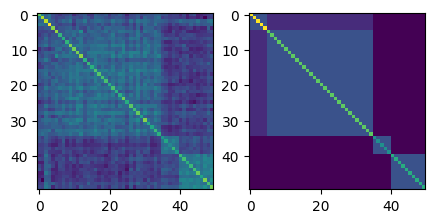

In [21]:
plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(data @ data.T)
plt.subplot(1,2,2)
plt.imshow(COV)


Text(0.5, 1.0, 'Integration weights')

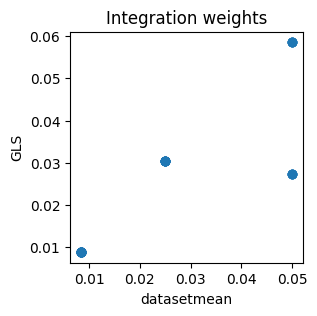

In [24]:
# Look at the integration weights of dataset_mean and GLS
methods = ['datasetmean','GLS']
W = get_integration_weights(methods, sigma2_g,dataset_cov, dataset_size=size,subject_var=var)
plt.figure(figsize=(3,3))
plt.scatter(W[0],W[1])
plt.xlabel('datasetmean')
plt.ylabel('GLS')
plt.title('Integration weights')

Text(0.5, 1.0, 'R')

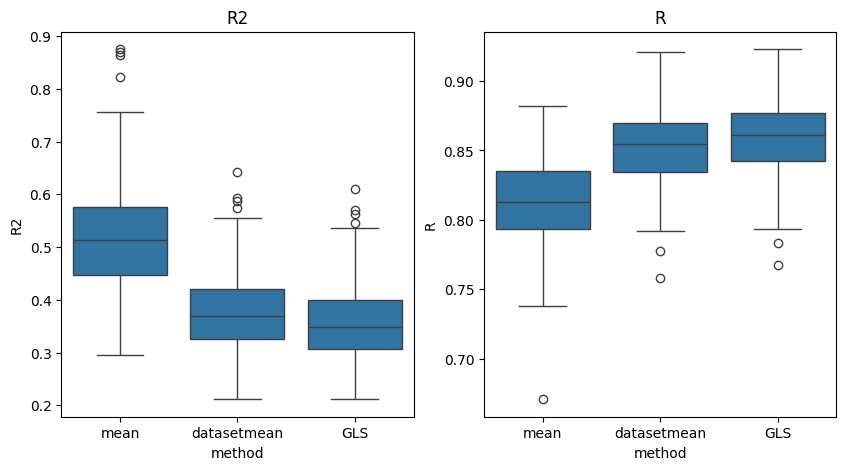

In [23]:
R = simulate_estimation(sigma2_g,dataset_cov,dataset_size=size,subject_var=var, P=100,n_sim=200)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x='method',y='R2',data=R)
plt.title('R2')
plt.subplot(1,2,2)
sns.boxplot(x='method',y='R',data=R)
plt.title('R')
